# Parvaneh SoleimanyBaraijany
# 0001038101

# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow import keras
from keras.layers import *
from keras.models import *
import numpy as np
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=0)
        x_data = np.transpose(x_data)
        y_data = np.transpose(y_data)
        yield x_data, y_data

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [5]:
batchsize = 64
inputShape = (32,32,1)

In [6]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, 1)
validation_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

In [7]:
def generate_from_train(n_samples):
  x = np.zeros((n_samples,32,32,1))
  y = np.zeros((n_samples,32,32,2))
  for i in range(n_samples):
      x[i], y[i] = next(train_generator)
  return x, y

In [8]:
x_train, y_train = generate_from_train(40000)
    
print(x_train.shape)
print(y_train.shape)

(40000, 32, 32, 1)
(40000, 32, 32, 2)


In [9]:
x_validation, y_validation = generate_from_train(10000)
    
print(x_validation.shape)
print(y_validation.shape)

(10000, 32, 32, 1)
(10000, 32, 32, 2)


In [10]:
def generate_from_test(n_samples):
  x = np.zeros((n_samples,32,32,1))
  y = np.zeros((n_samples,32,32,2))
  for i in range(n_samples):
      x[i], y[i] = next(test_generator)
  return x, y

In [11]:
x_test, y_test = generate_from_test(20000)
    
print(x_test.shape)
print(y_test.shape)

(20000, 32, 32, 1)
(20000, 32, 32, 2)


Here we show a sample from the train set

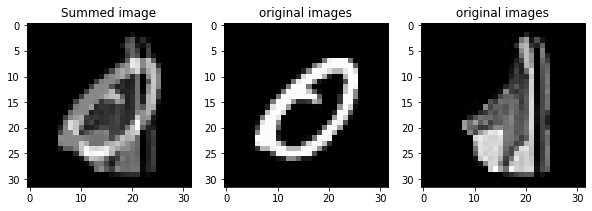

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axes[0].set_title('Summed image')
axes[0].imshow(x_train[0,:,:,0],cmap='gray', interpolation='nearest');
axes[1].set_title('original images')
axes[1].imshow(y_train[0,:,:,0],cmap='gray', interpolation='nearest');
axes[2].set_title('original images')
axes[2].imshow(y_train[0,:,:,1],cmap='gray', interpolation='nearest');

# RIDNet neural network
In this project I take advantage of the framework introduced in this repository:

https://github.com/Captain272/Image-Denoising


In [15]:
def EAM(input):
  channels = 64
  s = (3, 3)
  x=Conv2D(channels, (3, 3), dilation_rate=1,padding='same',activation='relu')(input)
  x=Conv2D(channels, (3, 3), dilation_rate=2,padding='same',activation='relu')(x)

  y=Conv2D(channels, (3, 3), dilation_rate=3,padding='same',activation='relu')(input)
  y=Conv2D(channels, (3, 3), dilation_rate=4,padding='same',activation='relu')(y)

  z=Concatenate(axis=-1)([x,y])
  z=Conv2D(channels, (3, 3),padding='same',activation='relu')(z)
  add_1=Add()([z, input])

  z=Conv2D(channels, (3, 3),padding='same',activation='relu')(add_1)
  z=Conv2D(channels, (3, 3),padding='same')(z)
  add_2=Add()([z,add_1])
  add_2 = Activation('relu')(add_2)

  z=Conv2D(channels, (3, 3),padding='same',activation='relu')(add_2)
  z=Conv2D(channels, (3, 3),padding='same',activation='relu')(z)
  z=Conv2D(channels, (3, 3),padding='same')(z)
  add_3=Add()([z,add_2])
  add_3 = Activation('relu')(add_3)

  z = GlobalAveragePooling2D(keepdims=True)(add_3)
  
  z=Conv2D(4, 3,padding='same',activation='relu')(z)
  z=Conv2D(channels, 3,padding='same',activation='sigmoid')(z)
  mul=Multiply()([z, add_3])

  return mul

In [20]:
def RIDNET():

  input = Input(inputShape, name='input')
  feat_extraction =Conv2D(64, (3, 3),padding='same')(input)
  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_3=EAM(eam_2)
  eam_4=EAM(eam_3)
  eam_5=EAM(eam_4)
  x=Conv2D(2, (3, 3),padding='same')(eam_5)
  add_2=Add()([x, input])
  
  model=Model(input,add_2)

  return model

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(6908)
ridnet = RIDNET()

In [22]:
ridnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

In [23]:
ridnet.compile(optimizer="adam", loss="logcosh", metrics=["mse"])

Here we fit the model with 50 epoches

In [24]:
model_history = ridnet.fit(
    x= x_train,
    y= y_train,
    validation_data = (x_validation, y_validation),
    epochs= 50,
    batch_size= batchsize,
    shuffle= True
)

Epoch 1/50
625/625 [==============================] - 177s 279ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0045 - val_mse: 0.0092
Epoch 2/50
625/625 [==============================] - 173s 277ms/step - loss: 9.0024e-04 - mse: 0.0018 - val_loss: 5.6431e-04 - val_mse: 0.0012
Epoch 3/50
625/625 [==============================] - 173s 277ms/step - loss: 7.7982e-04 - mse: 0.0016 - val_loss: 5.4089e-04 - val_mse: 0.0011
Epoch 4/50
625/625 [==============================] - 173s 276ms/step - loss: 5.1830e-04 - mse: 0.0011 - val_loss: 4.7389e-04 - val_mse: 9.6716e-04
Epoch 5/50
625/625 [==============================] - 173s 276ms/step - loss: 4.4473e-04 - mse: 9.0511e-04 - val_loss: 4.0782e-04 - val_mse: 8.2945e-04
Epoch 6/50
625/625 [==============================] - 173s 277ms/step - loss: 4.2712e-04 - mse: 8.6998e-04 - val_loss: 3.8494e-04 - val_mse: 7.8418e-04
Epoch 7/50
625/625 [==============================] - 173s 276ms/step - loss: 3.3795e-04 - mse: 6.8528e-04 - val_loss: 3.467

# MSE Score on test data

# Evaluation of the model on test data

# mse score on test set is equal to : 0.00052

In [25]:
results = ridnet.evaluate(x_test, y_test)

print('Test loss:', results[0])
print('Test mean_squared_error:', results[1])

625/625 [==============================] - 31s 48ms/step - loss: 2.5932e-04 - mse: 5.2875e-04
Test loss: 0.00025931737036444247
Test mean_squared_error: 0.0005287536769174039


In [28]:
ridnet.save_weights('my_model_weights.h5')
ridnet.save('my_model.h5')

Here we plot of "mse" and "loss" of the model related to the process of training

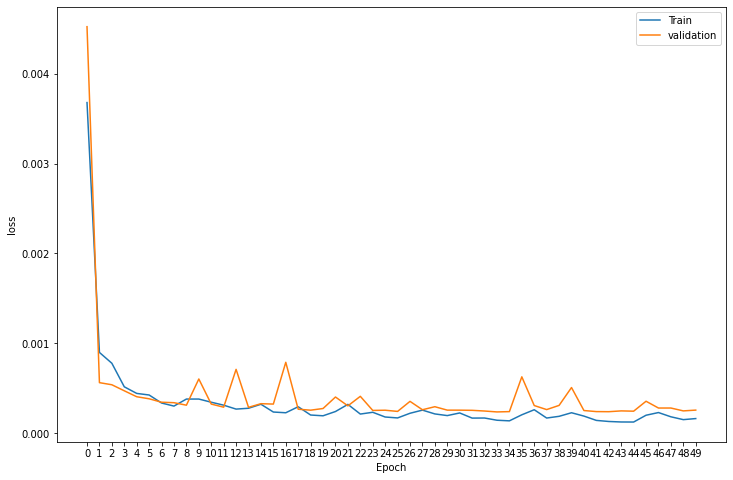

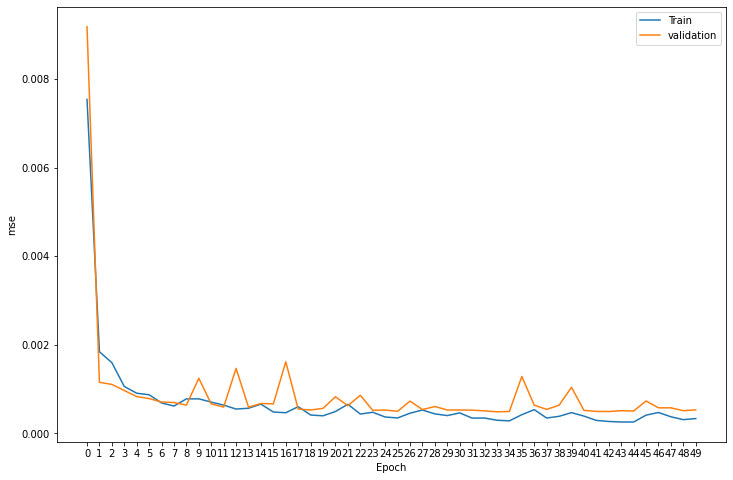

In [26]:
plt.figure(figsize=(12,8))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'validation'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.xticks(ticks=model_history.epoch, labels=model_history.epoch)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(model_history.history['mse'])
plt.plot(model_history.history['val_mse'])
plt.legend(['Train', 'validation'])
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.xticks(ticks=model_history.epoch, labels=model_history.epoch)
plt.show()

# calculate STD of the model

In [27]:
mse_scores = np.zeros(10)
for i in range(10):
  x_test, y_test = generate_from_test(20000)
  mse_scores[i] = ridnet.evaluate(x_test, y_test)[1]

mean_mse = mse_scores.mean()
std = mse_scores.std()
print("std =====> ", std)

625/625 [==============================] - 30s 48ms/step - loss: 2.6334e-04 - mse: 5.3711e-04
std =====>  3.790927776203908e-06
